# MySQL data will be processed to model a NN.

This `HTML` tag, used in a `Jupyter Notebook` cell, hides all error messages (standard error output) in the notebook by setting their display style to 'none'. It targets div elements with the class `output_stderr`, which are used to show error outputs. Source: https://stackoverflow.com/questions/58275372/how-do-i-make-a-div-set-to-style-display-none-by-default

In [1]:
%%html
<style>
    div.output_stderr { display: none; }
</style>                               

In [2]:
# Importing needed packages.

import time           # Built-in, no version.
import keras          # Version 2.14.0.
import numpy as np    # Version 1.26.4.
import pandas as pd   # Version 2.2.1.
import mysql.connector #Version 8.3.0
from sklearn import metrics          # Version 1.4.1.post1
from datetime import datetime        # Built-in, no version.
from keras.layers import Dense       # Version 2.14.0.
import matplotlib.pyplot as plt      # Version 3.5.1.
from keras.models import Sequential  # Version 2.14.0.
from pyspark.sql import SparkSession # Version 3.4.2.
from tensorflow.keras.optimizers import Adam  # Version 2.14.0
from sklearn.model_selection import train_test_split  # Version 1.4.1.post1
from sklearn.preprocessing import LabelEncoder, StandardScaler   # Version 1.4.1.post1 

2024-04-05 11:16:42.379661: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 11:16:42.632990: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 11:16:42.633026: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 11:16:42.634577: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 11:16:42.783575: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 11:16:42.785380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# 1. Connecting and extracting data from MySQL:

In [3]:
start_time = time.time() # Starting the clock.

# Asigning variables with our DB credentials
db_config = {
    'user': 'root',
    'password': 'password',
    'host': 'localhost',
    'database': 'people'
}

# Establishing a database connection
cnx = mysql.connector.connect(**db_config)

# Creating a cursor object
cursor = cnx.cursor()

# Selecting data from population_data table 
query = "SELECT * FROM people_data LIMIT 2000000"

# Execute the query
cursor.execute(query)

# Fetch the results
result = cursor.fetchall()

# Get column names
column_names = [i[0] for i in cursor.description]

# Close the cursor and connection
cursor.close()
cnx.close()
end_time = time.time() # Stopping the clock.

# Load results into a pandas DataFrame/
df = pd.DataFrame(result, columns=column_names)

# Display the DataFrame
df

,Index,User_Id,First_Name,Last_Name,Gender,Email,Phone,DOB,Job_Title
0,1,4defE49671cF860,Sydney,Shannon,Male,tvang@example.net,574-440-1423x9799,2020-07-09,Technical brewer
1,2,F89B87bCf8f210b,Regina,Lin,Male,helen14@example.net,001-273-664-2268x90121,1909-06-20,"Teacher, adult education"
2,3,Cad6052BDd5DEaf,Pamela,Blake,Female,brent05@example.org,927-880-5785x85266,1964-08-19,Armed forces operational officer
3,4,e83E46f80f629CD,Dave,Hoffman,Female,munozcraig@example.org,001-147-429-8340x608,2009-02-19,Ship broker
4,5,60AAc4DcaBcE3b6,Ian,Campos,Female,brownevelyn@example.net,166-126-4390,1997-10-02,Media planner
...,...,...,...,...,...,...,...,...,...
1999995,1999996,AbBE4F3Eb5df843,Susan,Ellison,Male,yward@example.net,855.222.4135x62040,1913-01-05,Research scientist (maths)
1999996,1999997,e71af3E8De63CDF,Cole,Sherman,Female,nbarnett@example.org,(130)829-9159x800,1977-04-15,Marketing executive
1999997,1999998,fAF0618097acD1B,Ethan,Leonard,Male,brett57@example.com,514.898.2376x3069,1960-08-14,Photographer
1999998,1999999,f1FC3346F68DFAb,Jordan,Waller,Female,harveykendra@example.com,6920274656,1911-09-05,Chartered accountant


In [4]:
execution_time = end_time - start_time
# Convert execution time to minutes and seconds
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)
print(f"MySQL fetching time: {minutes} minutes {seconds} seconds") # Usually it takes 4 seconds.

MySQL fetching time: 0 minutes 13 seconds


##  Calculating people's ages as it's crucial to have numerical values to model the NN.

In [5]:
# Calculating ppl age.
df['DOB'] = pd.to_datetime(df['DOB'])
df['Age'] = df['DOB'].apply(lambda x: datetime.now().year - x.year)

In [6]:
# Encoding "Sex" as binary values
encoder = LabelEncoder()
df['Gender'] = encoder.fit_transform(df['Gender'])  # Male will be 1, Female will be 0

In [7]:
# Selecting only needed columns
# Dropping columns except 'Sex', 'Date of birth', and 'Job Title'
df = df[['Gender', 'Job_Title','Age']]

# Renaming the column 'Job Title' to 'Job_Title'
df = df.rename(columns={'Job Title': 'Job_Title'})

df = df.reset_index(drop=True).rename_axis(None, axis=1)

df.head()

,Gender,Job_Title,Age
0,1,Technical brewer,4
1,1,"Teacher, adult education",115
2,0,Armed forces operational officer,60
3,0,Ship broker,15
4,0,Media planner,27


In [8]:
# Creating df1 to optimise NN, it will be used in further phases
df1 = df.copy()

In [9]:
X = df.iloc[:,1:] # selecting all columns except Gender| Dependent variables
y = df.iloc[:,0] # selecting Gender as our target variable | Independent variable

In [10]:
# Encoding "Job_Title".
encoder = LabelEncoder()
X['Job_Title'] = encoder.fit_transform(X['Job_Title'])  # Each job will have a number assigned 0, 1, 2....

In [11]:
X.head() # Dependent variables.

,Job_Title,Age
0,592,4
1,584,115
2,45,60
3,544,15
4,369,27


In [12]:
y.head() # Target Variable, 0 and 1.

0    1
1    1
2    0
3    0
4    0
Name: Gender, dtype: int64

# 2. NN Implementation.
## 2.1. Phase 1 intial model.

In [13]:
# Scaling
scaler = StandardScaler()   # Standardizing features by removing the mand and scaling to unit variance.
X = scaler.fit_transform(X) # Appliying the scaler to the dataset, normal distribution properties, x̄ = 0 and σ = 1.

In [14]:
# Building the model
model = Sequential() # linear stacks of layers, below layers are added, each layer has one input/output tensor.
model.add(Dense(12,input_dim=2,activation='relu')) # First layer, 12 neurons and two features.
model.add(Dense(8,activation='relu')) # Second layer, 8 neurons.
model.add(Dense(1,activation='sigmoid')) # Output layer, binary classification model it outputs 0 or 1.

In [15]:
# Compile the model
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])

* `binary_crossentropy`: It is used for binary classification problems. The loss function is a measure of how far the model's predictions are from the actual labels; it's the function that the training process will aim to minimize.
* `adam`: Algorithm used to update the weights of the network during training.
* `accuracy`: Keras will calculate the accuracy of the classification, to evaluate model performance.

In [16]:
# Train the model
start_time = time.time()
history = model.fit(X, y, epochs=100, batch_size=512, verbose=2)
end_time = time.time()

Epoch 1/100
3907/3907 - 5s - loss: 0.6932 - accuracy: 0.4997 - 5s/epoch - 1ms/step
Epoch 2/100
3907/3907 - 4s - loss: 0.6932 - accuracy: 0.4999 - 4s/epoch - 1ms/step
Epoch 3/100
3907/3907 - 3s - loss: 0.6932 - accuracy: 0.5002 - 3s/epoch - 891us/step
Epoch 4/100
3907/3907 - 3s - loss: 0.6931 - accuracy: 0.5001 - 3s/epoch - 877us/step
Epoch 5/100
3907/3907 - 3s - loss: 0.6931 - accuracy: 0.4998 - 3s/epoch - 885us/step
Epoch 6/100
3907/3907 - 3s - loss: 0.6931 - accuracy: 0.4996 - 3s/epoch - 879us/step
Epoch 7/100
3907/3907 - 3s - loss: 0.6931 - accuracy: 0.4994 - 3s/epoch - 873us/step
Epoch 8/100
3907/3907 - 3s - loss: 0.6931 - accuracy: 0.5002 - 3s/epoch - 876us/step
Epoch 9/100
3907/3907 - 3s - loss: 0.6931 - accuracy: 0.5006 - 3s/epoch - 867us/step
Epoch 10/100
3907/3907 - 3s - loss: 0.6931 - accuracy: 0.5002 - 3s/epoch - 886us/step
Epoch 11/100
3907/3907 - 3s - loss: 0.6931 - accuracy: 0.4999 - 3s/epoch - 847us/step
Epoch 12/100
3907/3907 - 3s - loss: 0.6931 - accuracy: 0.4997 - 3s/

Epoch 97/100
3907/3907 - 3s - loss: 0.6931 - accuracy: 0.5002 - 3s/epoch - 789us/step
Epoch 98/100
3907/3907 - 3s - loss: 0.6932 - accuracy: 0.4999 - 3s/epoch - 799us/step
Epoch 99/100
3907/3907 - 3s - loss: 0.6931 - accuracy: 0.5002 - 3s/epoch - 818us/step
Epoch 100/100
3907/3907 - 3s - loss: 0.6932 - accuracy: 0.5003 - 3s/epoch - 807us/step


* `epochs=100`: Specifying epochs number to train the model. An epoch is one complete pass through the entire training dataset. In this case, the model will go through the X and y data 100 times during the training process.
* `batch_size=512`: Defining the number of samples that will be propagated through the network before the model's internal parameters (weights) are updated. In this case, it processes in mini-batches of 512 samples at a time.
* `verbose=2`: This controls the verbosity of the training process output. verbose=2 will just mention the number of the epoch and the loss and accuracy for that epoch at each epoch end.

In [17]:
# Measuring training model time:
execution_time = end_time - start_time

# Convert execution time to minutes and seconds
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Training model time: {minutes} minutes {seconds} seconds")

Training model time: 5 minutes 26 seconds


In [18]:
# Convert history.history dict to a pandas DataFrame
history_df = pd.DataFrame(history.history)

Plotting Training scores, Accuracy and Loss.

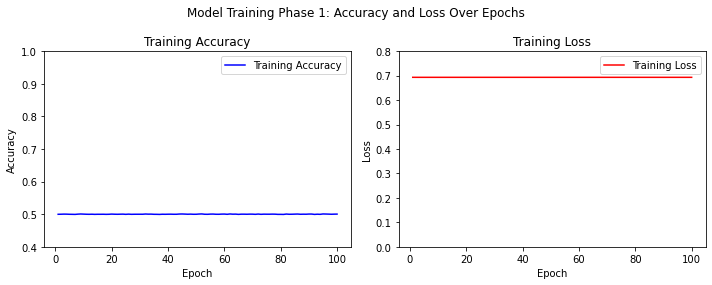

In [19]:
# Extracting epochs
epochs_range = np.array(range(1, len(history_df) + 1))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# Convert the Series to a numpy array
plt.plot(epochs_range, history_df['accuracy'].values, label='Training Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(.4, 1)  # Set the y-axis limits for accuracy
plt.legend()

plt.suptitle("Model Training Phase 1: Accuracy and Loss Over Epochs")

plt.subplot(1, 2, 2)
# Convert the Series to a numpy array
plt.plot(epochs_range, history_df['loss'].values, label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.8) # Set the y-axis limits for loss
plt.legend()

plt.tight_layout()
plt.show()

## Model Phase 1 evaluation:
The model is not performing at all, over 100 epochs, the model shows no improvement in learning, hovering around a 50% accuracy and 70% loss, indicating it's not effectively differentiating between classes.

## 2.2. Phase two adjusting the model.
A potential solution could involve treating each job as a distinct feature, transposing them into columns, and populating each column with the corresponding Age.

In [20]:
# Getting df1 backup
df1.head()

,Gender,Job_Title,Age
0,1,Technical brewer,4
1,1,"Teacher, adult education",115
2,0,Armed forces operational officer,60
3,0,Ship broker,15
4,0,Media planner,27


## Transposing the `Job_Title` into columns and assigning `Age` as the corresponding values.

In [21]:
# Add a unique identifier for each row within each group of 'Sex' and 'Job_Title'
df1['unique_id'] = df1.groupby(['Gender', 'Job_Title']).cumcount()

# Pivot the table, using 'Sex' and 'unique_id' as the index
df1 = df1.pivot_table(index=['Gender', 'unique_id'], columns='Job_Title', values='Age').reset_index()
df1  = df1.rename_axis(None, axis=1) # Index with no name as it should be

# Drop the 'unique_id' column as it's no longer needed, keeping 'Sex'
df1.drop('unique_id', axis=1, inplace=True)

# Display the result
df1

,Gender,Academic librarian,Accommodation manager,"Accountant, chartered","Accountant, chartered certified","Accountant, chartered management","Accountant, chartered public finance",Accounting technician,Actor,Actuary,...,Volunteer coordinator,Warden/ranger,Warehouse manager,Waste management officer,Water engineer,Water quality scientist,Web designer,Wellsite geologist,Writer,Youth worker
0,0,3.0,8.0,54.0,40.0,41.0,35.0,100.0,5.0,77.0,...,17.0,21.0,4.0,44.0,96.0,78.0,112.0,3.0,78.0,6.0
1,0,74.0,35.0,40.0,67.0,74.0,55.0,60.0,6.0,34.0,...,19.0,96.0,74.0,52.0,59.0,114.0,100.0,35.0,87.0,76.0
2,0,114.0,86.0,22.0,102.0,86.0,99.0,95.0,118.0,15.0,...,118.0,23.0,52.0,42.0,110.0,45.0,5.0,86.0,15.0,50.0
3,0,25.0,32.0,37.0,44.0,97.0,92.0,110.0,34.0,7.0,...,15.0,45.0,20.0,44.0,84.0,90.0,31.0,54.0,63.0,3.0
4,0,53.0,16.0,60.0,27.0,57.0,60.0,77.0,70.0,40.0,...,65.0,21.0,112.0,64.0,94.0,56.0,83.0,94.0,104.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3384,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3385,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3386,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3387,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# By dropping NaN values, we ensure the model does not receive any NaN values as input.
df1 = df1.dropna().reset_index(drop=True) 

In [23]:
df1

,Gender,Academic librarian,Accommodation manager,"Accountant, chartered","Accountant, chartered certified","Accountant, chartered management","Accountant, chartered public finance",Accounting technician,Actor,Actuary,...,Volunteer coordinator,Warden/ranger,Warehouse manager,Waste management officer,Water engineer,Water quality scientist,Web designer,Wellsite geologist,Writer,Youth worker
0,0,3.0,8.0,54.0,40.0,41.0,35.0,100.0,5.0,77.0,...,17.0,21.0,4.0,44.0,96.0,78.0,112.0,3.0,78.0,6.0
1,0,74.0,35.0,40.0,67.0,74.0,55.0,60.0,6.0,34.0,...,19.0,96.0,74.0,52.0,59.0,114.0,100.0,35.0,87.0,76.0
2,0,114.0,86.0,22.0,102.0,86.0,99.0,95.0,118.0,15.0,...,118.0,23.0,52.0,42.0,110.0,45.0,5.0,86.0,15.0,50.0
3,0,25.0,32.0,37.0,44.0,97.0,92.0,110.0,34.0,7.0,...,15.0,45.0,20.0,44.0,84.0,90.0,31.0,54.0,63.0,3.0
4,0,53.0,16.0,60.0,27.0,57.0,60.0,77.0,70.0,40.0,...,65.0,21.0,112.0,64.0,94.0,56.0,83.0,94.0,104.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2902,1,23.0,38.0,86.0,36.0,6.0,61.0,53.0,70.0,80.0,...,82.0,87.0,72.0,100.0,35.0,18.0,22.0,86.0,71.0,92.0
2903,1,23.0,78.0,43.0,65.0,109.0,33.0,109.0,94.0,76.0,...,93.0,22.0,107.0,25.0,87.0,108.0,16.0,19.0,47.0,81.0
2904,1,18.0,61.0,93.0,33.0,23.0,6.0,104.0,91.0,36.0,...,31.0,81.0,24.0,81.0,112.0,78.0,26.0,43.0,97.0,12.0
2905,1,60.0,59.0,75.0,55.0,3.0,87.0,50.0,71.0,98.0,...,101.0,118.0,103.0,88.0,88.0,18.0,67.0,29.0,22.0,86.0


In [24]:
X = df1.iloc[:,1:] # selecting all columns except Gender | Dependent variable
y = df1.iloc[:,0] # selecting column Gender as our target variable | Independent variable

In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [26]:
# Building the model, it has more features than the previous one
model = Sequential()
model.add(Dense(12,input_dim=639,activation='relu')) # First layer, 12 neurons and 639 features.
model.add(Dense(8,activation='relu')) # Second layer, 8 neurons.
model.add(Dense(1,activation='sigmoid')) # Output layer, binary classification model it outputs 0 or 1.

In [27]:
# Compile the model
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])

In [28]:
# Train the model
start_time = time.time()
history = model.fit(X, y, epochs=100, batch_size=512, verbose=2)
end_time = time.time()

Epoch 1/100
6/6 - 0s - loss: 0.7770 - accuracy: 0.5002 - 453ms/epoch - 75ms/step
Epoch 2/100
6/6 - 0s - loss: 0.7256 - accuracy: 0.5483 - 14ms/epoch - 2ms/step
Epoch 3/100
6/6 - 0s - loss: 0.6905 - accuracy: 0.5831 - 12ms/epoch - 2ms/step
Epoch 4/100
6/6 - 0s - loss: 0.6628 - accuracy: 0.6103 - 13ms/epoch - 2ms/step
Epoch 5/100
6/6 - 0s - loss: 0.6409 - accuracy: 0.6409 - 12ms/epoch - 2ms/step
Epoch 6/100
6/6 - 0s - loss: 0.6220 - accuracy: 0.6646 - 12ms/epoch - 2ms/step
Epoch 7/100
6/6 - 0s - loss: 0.6053 - accuracy: 0.6890 - 13ms/epoch - 2ms/step
Epoch 8/100
6/6 - 0s - loss: 0.5892 - accuracy: 0.7083 - 11ms/epoch - 2ms/step
Epoch 9/100
6/6 - 0s - loss: 0.5736 - accuracy: 0.7272 - 12ms/epoch - 2ms/step
Epoch 10/100
6/6 - 0s - loss: 0.5585 - accuracy: 0.7410 - 11ms/epoch - 2ms/step
Epoch 11/100
6/6 - 0s - loss: 0.5436 - accuracy: 0.7582 - 16ms/epoch - 3ms/step
Epoch 12/100
6/6 - 0s - loss: 0.5289 - accuracy: 0.7730 - 11ms/epoch - 2ms/step
Epoch 13/100
6/6 - 0s - loss: 0.5138 - accuracy

In [29]:
execution_time = end_time - start_time

# Convert execution time to minutes and seconds
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Training model time: {minutes} minutes {seconds} seconds")

Training model time: 0 minutes 2 seconds


In [30]:
# Converting history into a DataFrame
history_df1 = pd.DataFrame(history.history)

Plotting Training scores, Accuracy and Loss.

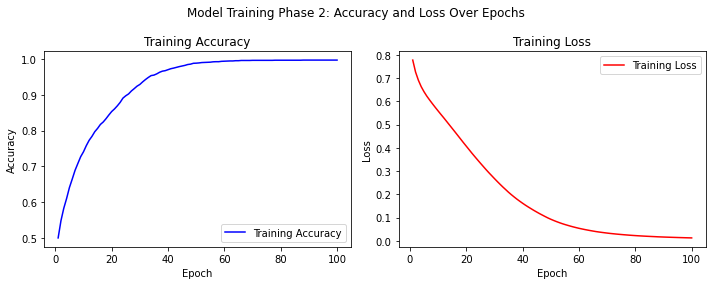

In [31]:
# Extracting epochs
epochs_range = np.array(range(1, len(history_df1) + 1))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# Convert the Series to a numpy array
plt.plot(epochs_range, history_df1['accuracy'].values, label='Training Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle("Model Training Phase 2: Accuracy and Loss Over Epochs")

plt.subplot(1, 2, 2)
# Convert the Series to a numpy array
plt.plot(epochs_range, history_df1['loss'].values, label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model Phase 2 evaluation:
The model demonstrates consistent improvement, starting with an accuracy of 50.05% and reaching 99.90% by the 100th epoch, with the loss decreasing steadily from 0.7821 to 0.0129.<br>
Compared to model phase 1 the improvement is significant, however these good resuts need to be validated, by introducing validation (Barry-Straume et al., 2019). Training accuracy and loss must be validated

## 2.3. Model Phase 3 Validation:

In [32]:
# Split the data into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(12, input_dim=639, activation='relu'))  # First layer
model.add(Dense(8, activation='relu'))  # Second layer
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Train the model
start_time = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512, verbose=2)
end_time = time.time()

Epoch 1/100
5/5 - 1s - loss: 0.7838 - accuracy: 0.5127 - val_loss: 0.7812 - val_accuracy: 0.4948 - 529ms/epoch - 106ms/step
Epoch 2/100
5/5 - 0s - loss: 0.7225 - accuracy: 0.5630 - val_loss: 0.7705 - val_accuracy: 0.4983 - 29ms/epoch - 6ms/step
Epoch 3/100
5/5 - 0s - loss: 0.6814 - accuracy: 0.5923 - val_loss: 0.7618 - val_accuracy: 0.4983 - 27ms/epoch - 5ms/step
Epoch 4/100
5/5 - 0s - loss: 0.6476 - accuracy: 0.6292 - val_loss: 0.7556 - val_accuracy: 0.5000 - 28ms/epoch - 6ms/step
Epoch 5/100
5/5 - 0s - loss: 0.6201 - accuracy: 0.6697 - val_loss: 0.7515 - val_accuracy: 0.5000 - 30ms/epoch - 6ms/step
Epoch 6/100
5/5 - 0s - loss: 0.5967 - accuracy: 0.6951 - val_loss: 0.7486 - val_accuracy: 0.5052 - 29ms/epoch - 6ms/step
Epoch 7/100
5/5 - 0s - loss: 0.5759 - accuracy: 0.7114 - val_loss: 0.7464 - val_accuracy: 0.5069 - 27ms/epoch - 5ms/step
Epoch 8/100
5/5 - 0s - loss: 0.5569 - accuracy: 0.7363 - val_loss: 0.7455 - val_accuracy: 0.5069 - 28ms/epoch - 6ms/step
Epoch 9/100
5/5 - 0s - loss: 

Epoch 69/100
5/5 - 0s - loss: 0.0350 - accuracy: 0.9966 - val_loss: 1.6120 - val_accuracy: 0.5275 - 26ms/epoch - 5ms/step
Epoch 70/100
5/5 - 0s - loss: 0.0336 - accuracy: 0.9966 - val_loss: 1.6284 - val_accuracy: 0.5258 - 26ms/epoch - 5ms/step
Epoch 71/100
5/5 - 0s - loss: 0.0322 - accuracy: 0.9966 - val_loss: 1.6446 - val_accuracy: 0.5258 - 26ms/epoch - 5ms/step
Epoch 72/100
5/5 - 0s - loss: 0.0309 - accuracy: 0.9966 - val_loss: 1.6607 - val_accuracy: 0.5275 - 26ms/epoch - 5ms/step
Epoch 73/100
5/5 - 0s - loss: 0.0296 - accuracy: 0.9966 - val_loss: 1.6772 - val_accuracy: 0.5275 - 28ms/epoch - 6ms/step
Epoch 74/100
5/5 - 0s - loss: 0.0282 - accuracy: 0.9974 - val_loss: 1.6928 - val_accuracy: 0.5292 - 26ms/epoch - 5ms/step
Epoch 75/100
5/5 - 0s - loss: 0.0270 - accuracy: 0.9974 - val_loss: 1.7085 - val_accuracy: 0.5326 - 26ms/epoch - 5ms/step
Epoch 76/100
5/5 - 0s - loss: 0.0259 - accuracy: 0.9974 - val_loss: 1.7239 - val_accuracy: 0.5326 - 26ms/epoch - 5ms/step
Epoch 77/100
5/5 - 0s - 

In [33]:
execution_time = end_time - start_time

# Convert execution time to minutes and seconds
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Training model time: {minutes} minutes {seconds} seconds")

Training model time: 0 minutes 5 seconds


Plotting Training and Validation scores for Accuracy and Loss.

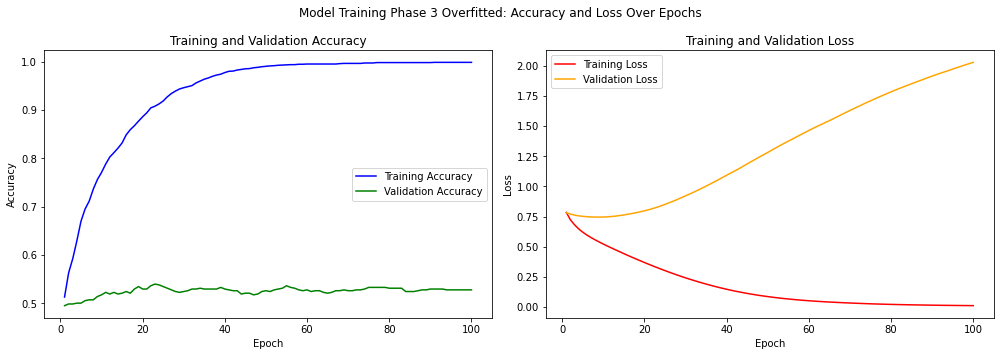

In [34]:

# Converting history into a DataFrame
history_df = pd.DataFrame(history.history)

# Extracting epochs
epochs_range = np.array(range(1, len(history_df) + 1))


# Plot Training and Validation Accuracy
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_df['accuracy'].values, label='Training Accuracy', color='blue')
plt.plot(epochs_range, history_df['val_accuracy'].values, label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_df['loss'].values, label='Training Loss', color='red')
plt.plot(epochs_range, history_df['val_loss'].values, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("Model Training Phase 3 Overfitted: Accuracy and Loss Over Epochs")
plt.tight_layout()
plt.show()

## Model Phase 3 evaluation:
The model attained near-perfect training accuracy, reaching 99.91% over 100 epochs, while validation accuracy plateaued at approximately 54.98%. The training loss decreased significantly from 0.7401 to 0.0201, reflecting enhanced performance during training. However, the validation loss rose from 0.7332 to 1.9686, indicating potential overfitting as it steadily increased.

### Training vs. Validation Performance

An overfitted model will perform well on the training data but poorly on unseen validation or test data. If the accuracy on the training data is **significantly higher** than on the validation data, it may be a sign of overfitting.

### Training Performance Over Time

If the accuracy continues to improve and the loss decreases over time on the training set but not on the validation set, it may indicate overfitting. We can clearly see that the model is overfitting; it performs well on training data but poorly on validation.



## 2.4. Model Phase 3 addressing overfitting:
A solution could be to **add more data to the model**, following the recommendation of the paper *`Is Your Dataset Big Enough?`* by Alwosheel, van Cranenburgh, and Chorus (2018), which advocates for augmenting the dataset to improve the model.

In [35]:
# Assuming `df` is your existing DataFrame
df1 = pd.concat([df1]*4, ignore_index=True)

In [36]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11628 entries, 0 to 11627
Columns: 640 entries, Gender to Youth worker
dtypes: float64(639), int64(1)
memory usage: 56.8 MB


In [37]:
X = df1.iloc[:,1:] # selecting all columns except Gender | Dependent variable
y = df1.iloc[:,0] # selecting column Gender as our target variable | Independent variable

In [38]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [39]:
# Split the data into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(12, input_dim=639, activation='relu'))  # First layer
model.add(Dense(8, activation='relu'))  # Second layer
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Train the model
start_time = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512, verbose=2)
end_time = time.time()

Epoch 1/100
19/19 - 0s - loss: 0.6931 - accuracy: 0.5400 - val_loss: 0.6728 - val_accuracy: 0.5873 - 404ms/epoch - 21ms/step
Epoch 2/100
19/19 - 0s - loss: 0.6569 - accuracy: 0.6270 - val_loss: 0.6522 - val_accuracy: 0.6212 - 68ms/epoch - 4ms/step
Epoch 3/100
19/19 - 0s - loss: 0.6290 - accuracy: 0.6701 - val_loss: 0.6277 - val_accuracy: 0.6599 - 70ms/epoch - 4ms/step
Epoch 4/100
19/19 - 0s - loss: 0.5964 - accuracy: 0.7114 - val_loss: 0.5988 - val_accuracy: 0.7016 - 66ms/epoch - 3ms/step
Epoch 5/100
19/19 - 0s - loss: 0.5592 - accuracy: 0.7506 - val_loss: 0.5644 - val_accuracy: 0.7300 - 67ms/epoch - 4ms/step
Epoch 6/100
19/19 - 0s - loss: 0.5168 - accuracy: 0.7828 - val_loss: 0.5296 - val_accuracy: 0.7541 - 66ms/epoch - 3ms/step
Epoch 7/100
19/19 - 0s - loss: 0.4727 - accuracy: 0.8088 - val_loss: 0.4936 - val_accuracy: 0.7786 - 63ms/epoch - 3ms/step
Epoch 8/100
19/19 - 0s - loss: 0.4283 - accuracy: 0.8295 - val_loss: 0.4588 - val_accuracy: 0.8014 - 65ms/epoch - 3ms/step
Epoch 9/100
19

Epoch 68/100
19/19 - 0s - loss: 0.0025 - accuracy: 0.9997 - val_loss: 0.0415 - val_accuracy: 0.9961 - 56ms/epoch - 3ms/step
Epoch 69/100
19/19 - 0s - loss: 0.0025 - accuracy: 0.9997 - val_loss: 0.0416 - val_accuracy: 0.9961 - 69ms/epoch - 4ms/step
Epoch 70/100
19/19 - 0s - loss: 0.0024 - accuracy: 0.9997 - val_loss: 0.0416 - val_accuracy: 0.9961 - 52ms/epoch - 3ms/step
Epoch 71/100
19/19 - 0s - loss: 0.0024 - accuracy: 0.9997 - val_loss: 0.0417 - val_accuracy: 0.9961 - 67ms/epoch - 4ms/step
Epoch 72/100
19/19 - 0s - loss: 0.0023 - accuracy: 0.9997 - val_loss: 0.0418 - val_accuracy: 0.9961 - 51ms/epoch - 3ms/step
Epoch 73/100
19/19 - 0s - loss: 0.0023 - accuracy: 0.9997 - val_loss: 0.0420 - val_accuracy: 0.9961 - 68ms/epoch - 4ms/step
Epoch 74/100
19/19 - 0s - loss: 0.0022 - accuracy: 0.9997 - val_loss: 0.0421 - val_accuracy: 0.9961 - 52ms/epoch - 3ms/step
Epoch 75/100
19/19 - 0s - loss: 0.0022 - accuracy: 0.9997 - val_loss: 0.0421 - val_accuracy: 0.9961 - 66ms/epoch - 3ms/step
Epoch 76

In [40]:
execution_time = end_time - start_time

# Convert execution time to minutes and seconds
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Training model time: {minutes} minutes {seconds} seconds")

Training model time: 0 minutes 6 seconds


Plotting Training and Validation scores for Accuracy and Loss.

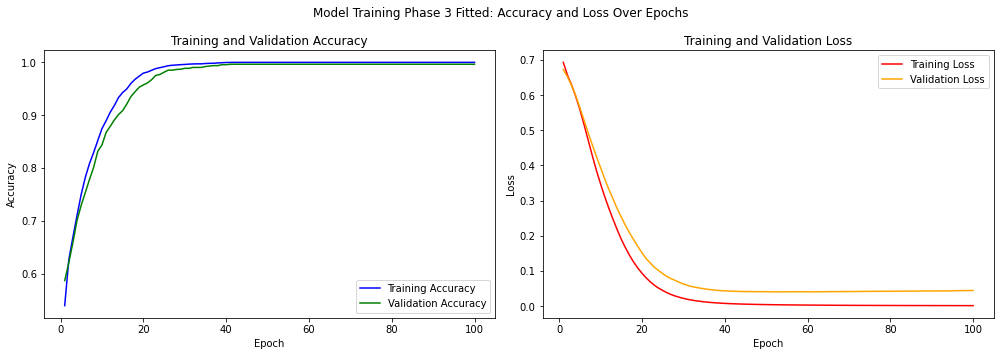

In [41]:
# Converting history into a DataFrame
history_df = pd.DataFrame(history.history)

# Extracting epochs
epochs_range = np.array(range(1, len(history_df) + 1))


# Plot Training and Validation Accuracy
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_df['accuracy'].values, label='Training Accuracy', color='blue')
plt.plot(epochs_range, history_df['val_accuracy'].values, label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_df['loss'].values, label='Training Loss', color='red')
plt.plot(epochs_range, history_df['val_loss'].values, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("Model Training Phase 3 Fitted: Accuracy and Loss Over Epochs")
plt.tight_layout()
plt.show()

## Model Phase 3 addressing overfitting evaluation:
Overfitting was mitigated. The model shows great learning over 100 epochs, with training accuracy climbing to 99.9% and validation accuracy reaching a high of 99.53%. The loss for both training and validation steadily decreased, indicating that the model consistently improved its predictions over time without any apparent overfitting, as shown by the close tracking of validation loss alongside the training loss.

### Validation Loss Decreases Consistently
Both the training and validation losses are decreasing over the epochs, which indicates that the model is learning and generalizing well to unseen data.

### Close Training and Validation Accuracy
The training and validation accuracies are very close to each other and high, suggesting that the model performs similarly well on both the training set and the validation set. This is a good sign of generalization.

### Stable Performance Over Epochs
The accuracy reaches a high value and remains stable, which suggests that the model has learned the patterns in the data well without memorizing the training set.

Neural Network performance, with high accuracy on both the training and validation sets and decreasing loss over time, indicates effective learning without overfitting. The close alignment of training and validation metrics throughout training means a well-generalized model.

After adding data to the neural network, we can observe convergence between training and validation accuracy, as well as training and validation loss.

Due to the recording requirement and the time constraint of 5 to 7 minutes, I'm setting up a timestamp to show the exact time the script was run.

In [42]:
# Getting current date and time
current_time = datetime.now()

# Formatting the date and time in a readable format:
formatted_time = current_time.strftime('%B %d, %Y, %H:%M:%S')

# Print the formatted date and time
print(f"4.MySQL_Data_to_model_NN.ipynb was last run on: {formatted_time}")

4.MySQL_Data_to_model_NN.ipynb was last run on: April 05, 2024, 11:22:56
